<a href="https://colab.research.google.com/github/1biancaneves/POSTECH-techchallenge2/blob/main/POSTECH_eda_Ibovespa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1-2872183253.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tendencia'] = (df['Último'].shift(-1) > df['Último']).astype(int)
/tmp/ipython-input-1-2872183253.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'SMA_{window}'] = df['Último'].rolling(window=window).mean()
/tmp/ipython-input-1-2872183253.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Resumo estatístico das variáveis:
                                Data         Último       Abertura  \
count                           4974    4974.000000    4974.000000   
mean   2015-07-15 02:48:46.899879168   67812.770808   67783.930639   
min              2005-06-27 00:00:00     269.000000     293.000000   
25%              2010-07-07 06:00:00   48472.500000   48040.000000   
50%              2015-07-15 12:00:00   61615.000000   61595.500000   
75%              2020-07-27 18:00:00   98815.250000   98948.250000   
max              2025-07-25 00:00:00  141264.000000  141265.000000   
std                              NaN   34926.507154   35127.837312   

              Máxima         Mínima          Vol.         Var%    Tendencia  \
count    4974.000000    4974.000000  4.974000e+03  4974.000000  4974.000000   
mean    68681.259751   67472.936470  2.953794e+08     0.047565     0.517893   
min       315.000000     387.000000  1.121000e+05   -14.780000     0.000000   
25%     49272.00000

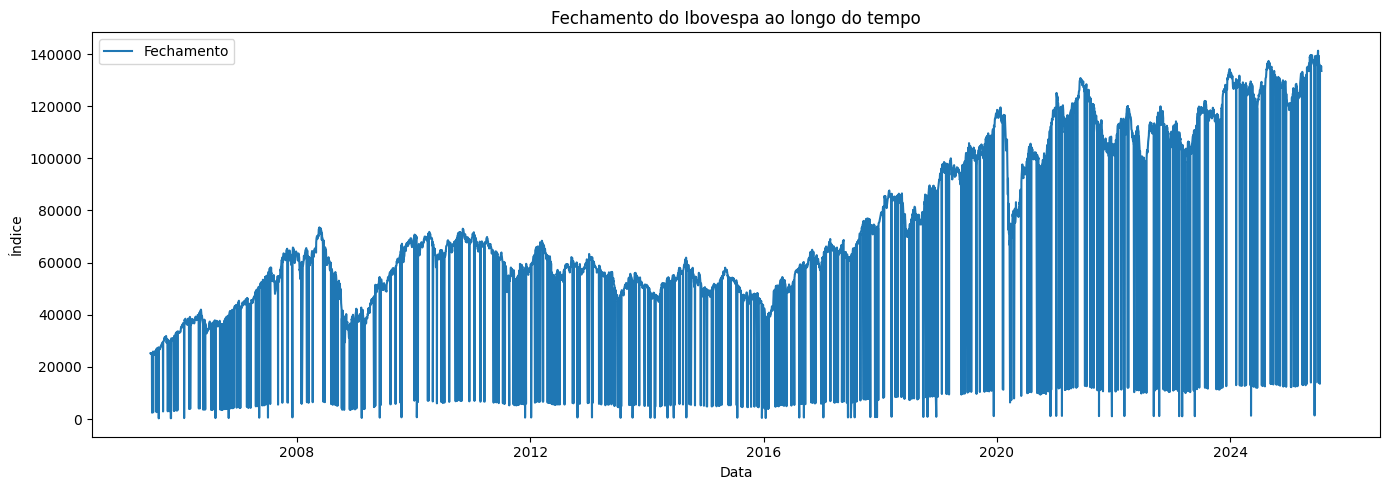

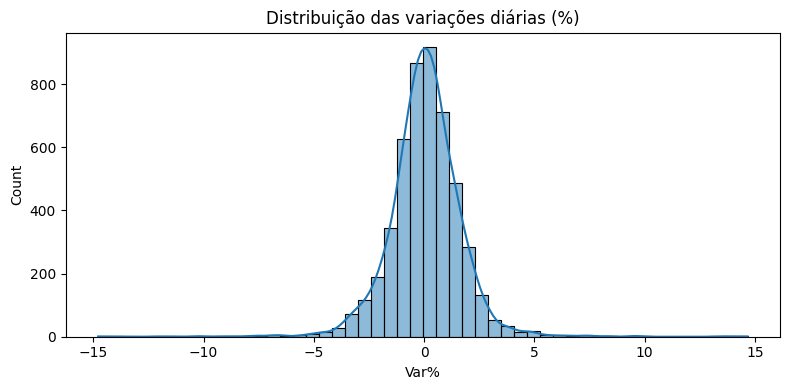

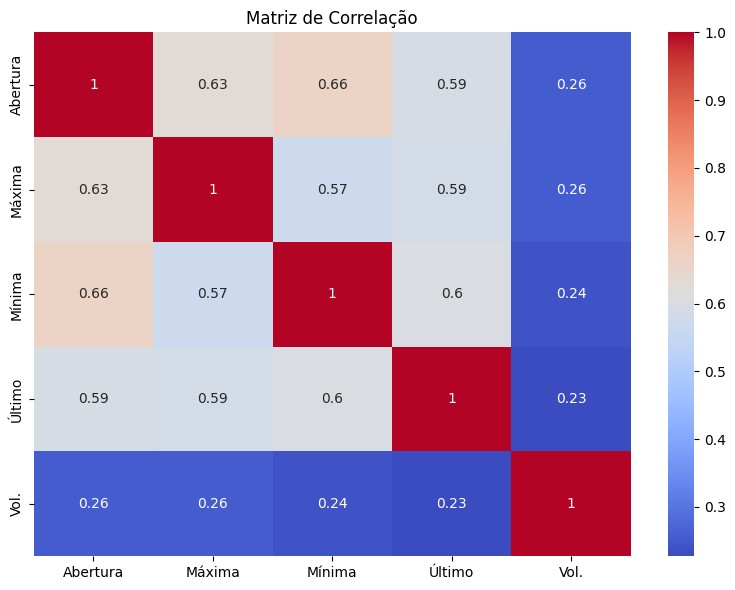

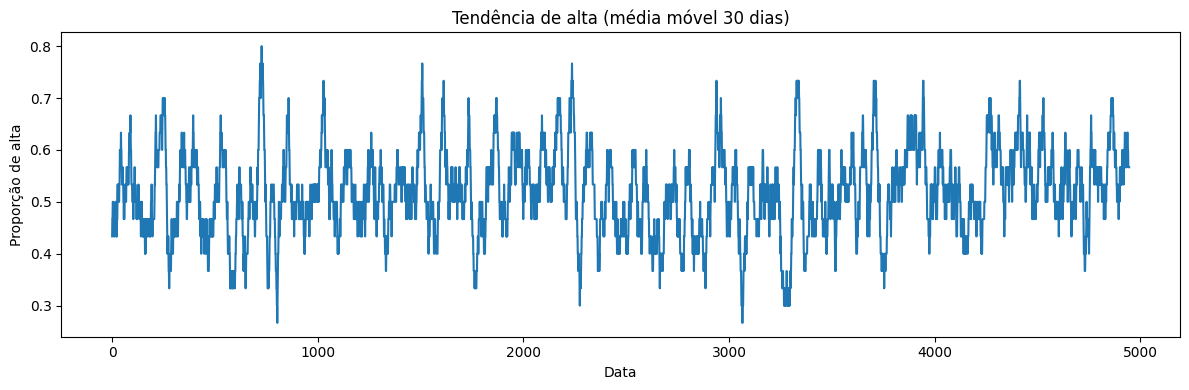

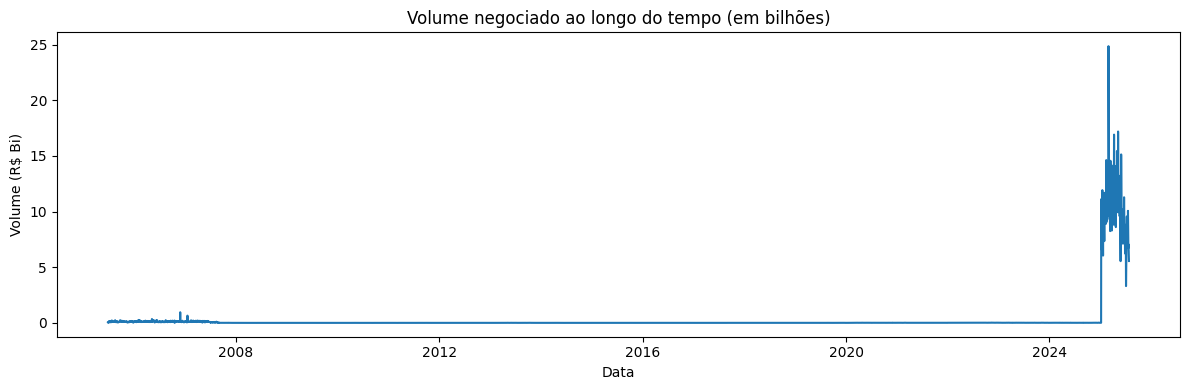

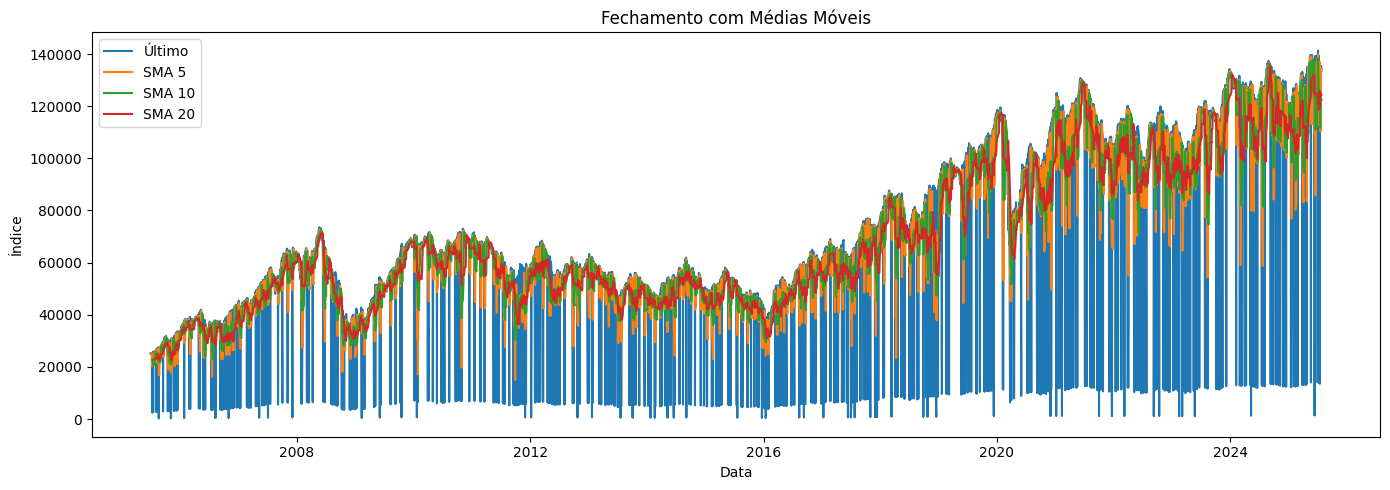

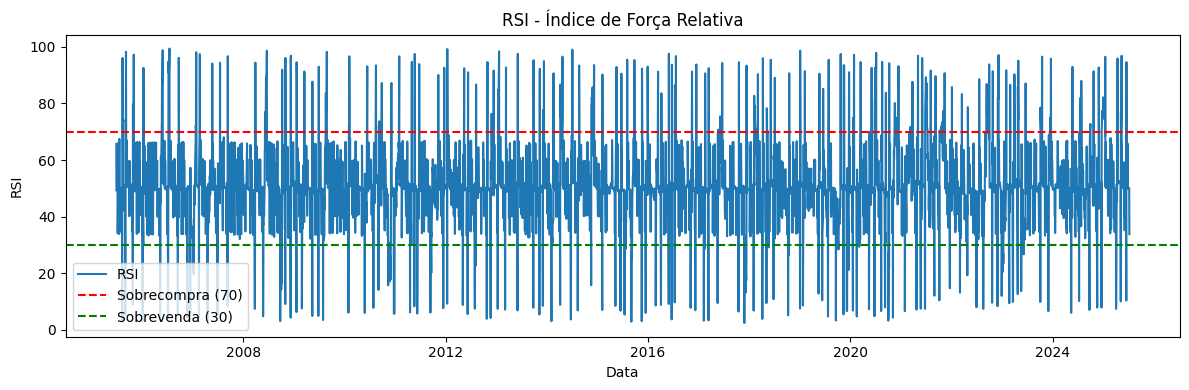

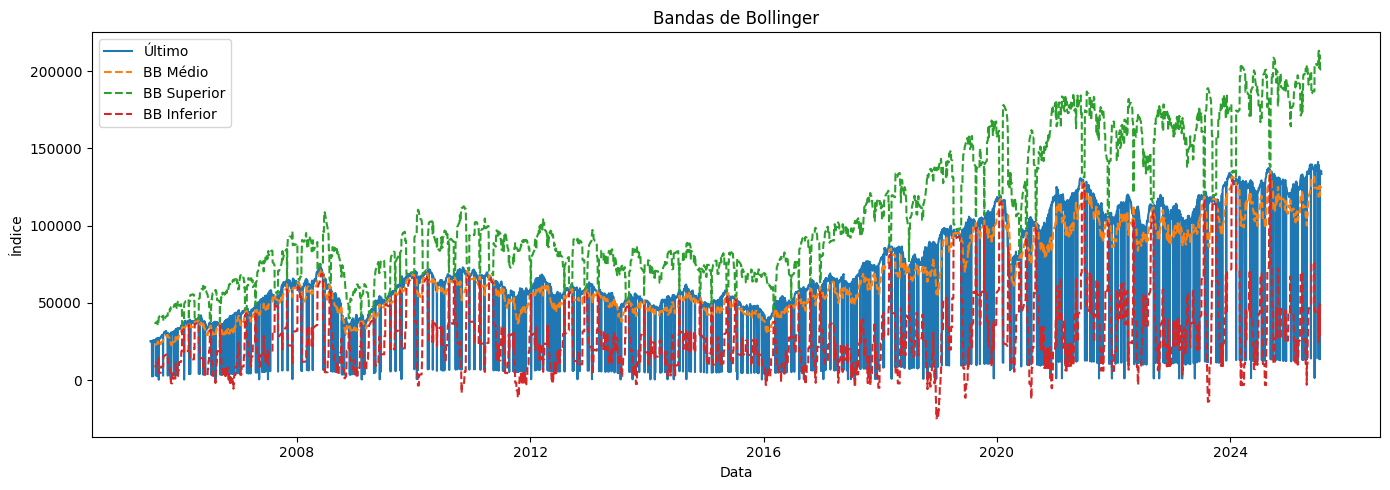

In [1]:
# Análise Exploratória de Dados (EDA) - Ibovespa com Indicadores Técnicos

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Carregar os dados
df = pd.read_csv("Dados Históricos - Ibovespa - 20 anos.csv")

# Padronizar colunas
colunas_numericas = ['Último', 'Abertura', 'Máxima', 'Mínima', 'Var%']

def clean(x):
    return float(str(x).replace('.', '').replace(',', '.').replace('%', ''))

df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df = df.sort_values('Data')
for col in colunas_numericas:
    df[col] = df[col].apply(clean)

df['Vol.'] = df['Vol.'].replace({'\\.': '', ',': '.', 'K': 'e3', 'M': 'e6', 'B': 'e9'}, regex=True)
df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
df = df.dropna()

# Tendência (1 = alta no próximo dia)
df['Tendencia'] = (df['Último'].shift(-1) > df['Último']).astype(int)

# =====================
# Indicadores Técnicos
# =====================

# Médias móveis simples
for window in [5, 10, 20]:
    df[f'SMA_{window}'] = df['Último'].rolling(window=window).mean()

# RSI (Relative Strength Index)
window_length = 14
delta = df['Último'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

gain = pd.Series(gain).rolling(window=window_length).mean()
loss = pd.Series(loss).rolling(window=window_length).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Bandas de Bollinger
df['BB_Middle'] = df['Último'].rolling(window=20).mean()
df['BB_Std'] = df['Último'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + (2 * df['BB_Std'])
df['BB_Lower'] = df['BB_Middle'] - (2 * df['BB_Std'])

# =====================
# Visualizações
# =====================

# 1. Resumo estatístico
print("Resumo estatístico das variáveis:")
print(df.describe())

# 2. Linha do tempo do fechamento
plt.figure(figsize=(14, 5))
plt.plot(df['Data'], df['Último'], label='Fechamento')
plt.title("Fechamento do Ibovespa ao longo do tempo")
plt.xlabel("Data")
plt.ylabel("Índice")
plt.legend()
plt.tight_layout()
plt.show()

# 3. Histograma de variações
plt.figure(figsize=(8, 4))
sns.histplot(df['Var%'], bins=50, kde=True)
plt.title("Distribuição das variações diárias (%)")
plt.xlabel("Var%")
plt.tight_layout()
plt.show()

# 4. Matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Abertura', 'Máxima', 'Mínima', 'Último', 'Vol.']].corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlação")
plt.tight_layout()
plt.show()

# 5. Tendência média móvel de 30 dias
plt.figure(figsize=(12, 4))
df['Tendencia'].rolling(30).mean().plot()
plt.title("Tendência de alta (média móvel 30 dias)")
plt.xlabel("Data")
plt.ylabel("Proporção de alta")
plt.tight_layout()
plt.show()

# 6. Volume negociado
plt.figure(figsize=(12, 4))
plt.plot(df['Data'], df['Vol.'] / 1e9)
plt.title("Volume negociado ao longo do tempo (em bilhões)")
plt.xlabel("Data")
plt.ylabel("Volume (R$ Bi)")
plt.tight_layout()
plt.show()

# 7. Médias móveis
plt.figure(figsize=(14, 5))
plt.plot(df['Data'], df['Último'], label='Último')
plt.plot(df['Data'], df['SMA_5'], label='SMA 5')
plt.plot(df['Data'], df['SMA_10'], label='SMA 10')
plt.plot(df['Data'], df['SMA_20'], label='SMA 20')
plt.title("Fechamento com Médias Móveis")
plt.xlabel("Data")
plt.ylabel("Índice")
plt.legend()
plt.tight_layout()
plt.show()

# 8. RSI
plt.figure(figsize=(12, 4))
plt.plot(df['Data'], df['RSI'], label='RSI')
plt.axhline(70, color='r', linestyle='--', label='Sobrecompra (70)')
plt.axhline(30, color='g', linestyle='--', label='Sobrevenda (30)')
plt.title("RSI - Índice de Força Relativa")
plt.xlabel("Data")
plt.ylabel("RSI")
plt.legend()
plt.tight_layout()
plt.show()

# 9. Bandas de Bollinger
plt.figure(figsize=(14, 5))
plt.plot(df['Data'], df['Último'], label='Último')
plt.plot(df['Data'], df['BB_Middle'], label='BB Médio', linestyle='--')
plt.plot(df['Data'], df['BB_Upper'], label='BB Superior', linestyle='--')
plt.plot(df['Data'], df['BB_Lower'], label='BB Inferior', linestyle='--')
plt.title("Bandas de Bollinger")
plt.xlabel("Data")
plt.ylabel("Índice")
plt.legend()
plt.tight_layout()
plt.show()
